# Notebook for the study of the different formation channels of sdB stars

In [159]:
## TODO:
# vary mass loss prescription
# vary envelope parameters
# vary accretion efficiency: 0-0.5-1
# angular momentum loss at L2 for accret eff at 0
# in compas: MACLEOD_LINEAR
# for non-degenerate accretors set to 1

## General imports and data

In [160]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image
from scipy.stats import gaussian_kde
from astropy import units as u

In [161]:
kg = ( 1.988416 * 10**(30) )**(-1) # in solar mass

m = ( 6.957 * 10**(8) )**(-1) # in solar radii

s = ( 86400 )**(-1) # in days

G =  6.67430 * 10**(-11) * kg**(-1) * s**(-2) * m**(3) # in (solar radii)^3 (solar masses)^(-1) days^(-2)

# use astropy for the units

In [162]:
# set path to data file
path = '/home/louism/Thesis/Thesis-Scripts/Grid/Set4/COMPAS_Output_set4/COMPAS_Output.h5'

# load the file
data = h5.File(path)

# inspect the data
list(data.keys())

['BSE_Common_Envelopes',
 'BSE_Double_Compact_Objects',
 'BSE_RLOF',
 'BSE_Supernovae',
 'BSE_Switch_Log',
 'BSE_System_Parameters',
 'Run_Details']

In [163]:
SLs = data['BSE_Switch_Log']
SPs = data['BSE_System_Parameters']
RLOF = data['BSE_RLOF']
CEs = data['BSE_Common_Envelopes']

### Some additional functions

In [164]:
def printCompasDetails(data, *seeds, mask=()):
    """
    Function to print the full Compas output for given seeds, optionally with an additional mask
    """
    list_of_keys = list(data.keys())

    # Check if seed parameter exists - if not, just print without (e.g RunDetails)
    if ('SEED' in list_of_keys) | ('SEED>MT' in list_of_keys): # Most output files 
        #SEED>MT is a relic from older versions, but we leave this in for backwards compatibility

        # Set the seed name parameter, mask on seeds as needed, and set the index
        seedVariableName='SEED' if ('SEED' in list_of_keys) else 'SEED>MT'
        list_of_keys.remove(seedVariableName) # this is the index above, don't want to include it
    
        allSeeds = data[seedVariableName][()]
        seedsMask = np.in1d(allSeeds, seeds)
        if len(seeds) == 0: # if any seed is included, do not reset the mask
            seedsMask = np.ones_like(allSeeds).astype(bool)
        if mask == ():
            mask = np.ones_like(allSeeds).astype(bool)
        mask &= seedsMask

        df = pd.DataFrame.from_dict({param: data[param][()][mask] for param in list(data.keys())}).set_index(seedVariableName).T

    else: # No seed parameter, so do custom print for Run Details

        # Get just the keys without the -Derivation suffix - those will be a second column
        keys_not_derivations = []
        for key in list_of_keys:
            if '-Derivation' not in key:
                keys_not_derivations.append(key)
        
        # Some parameter values are string types, formatted as np.bytes_, need to convert back
        def convert_strings(param_array):
            if isinstance(param_array[0], np.bytes_):
                return param_array.astype(str)
            else:
                return param_array

        df_keys = pd.DataFrame.from_dict({param: convert_strings(data[param][()]) for param in keys_not_derivations }).T
        nCols = df_keys.shape[1] # Required only because if we combine RDs, we get many columns (should fix later)
        df_keys.columns = ['Parameter']*nCols
        df_drvs = pd.DataFrame.from_dict({param: convert_strings(data[param+'-Derivation'][()]) for param in keys_not_derivations }).T
        df_drvs.columns = ['Derivation']*nCols
        df = pd.concat([df_keys, df_drvs], axis=1)

    # Add units as first col
    units_dict = {key:data[key].attrs['units'].astype(str) for key in list_of_keys}
    df.insert(loc=0, column='(units)', value=pd.Series(units_dict))
    return df


In [165]:
def getMtEvents(MT):                                     
    """
    This function takes in the `BSE_RLOF` output category from COMPAS, and returns the information
    on the Mass Transfer (MT) events that happen for each seed. The events do not have to be in order, 
    either chronologically or by seed, this function will reorder them as required.
    
    OUT:
        tuple of (returnedSeeds, returnedEvents, returnedTimes)
        returnedSeeds (list): ordered list of the unique seeds in the MT file
        returnedEvents (list): list of sublists, where each sublist contains all the MT events for a given seed.
            MT event tuples take the form :
            (stellarTypePrimary, stellarTypeSecondary, isRlof1, isRlof2, isCEE)
        returnTimes (list): is a list of sublists of times of each of the MT events
    """

    mtSeeds = MT['SEED'][()]
    mtTimes = MT['Time<MT'][()]
    mtPrimaryStype = MT['Stellar_Type(1)<MT'][()]
    mtSecondaryStype = MT['Stellar_Type(2)<MT'][()]
    mtIsRlof1 = MT['RLOF(1)>MT'][()] == 1
    mtIsRlof2 = MT['RLOF(2)>MT'][()] == 1
    mtIsCEE = MT['CEE>MT'][()] == 1

    # We want the return arrays sorted by seed, so sort here.
    mtSeedsInds = np.lexsort((mtTimes, mtSeeds)) # sort by seeds then times - lexsort sorts by the last column first...
    mtSeeds = mtSeeds[mtSeedsInds]  
    mtTimes = mtTimes[mtSeedsInds]  
    mtPrimaryStype = mtPrimaryStype[mtSeedsInds]
    mtSecondaryStype = mtSecondaryStype[mtSeedsInds]
    mtIsRlof1 = mtIsRlof1[mtSeedsInds]
    mtIsRlof2 = mtIsRlof2[mtSeedsInds]
    mtIsCEE = mtIsCEE[mtSeedsInds]

    # Process the MT events

    returnedSeeds = []                                      # array of seeds - will only contain seeds that have MT events
    returnedEvents = []                                     # array of MT events for each seed in returnedSeeds
    returnedTimes = []                                      # array of times for each event in returnedEvents (for each seed in returnedSeeds)

    lastSeed = -1                                           # initialize most recently processed seed

    for seedIndex, thisSeed in enumerate(mtSeeds):          # iterate over all RLOF file entries
        thisTime = mtTimes[seedIndex]                       # time for this RLOF file entry
        thisEvent = (mtPrimaryStype[seedIndex], mtSecondaryStype[seedIndex], 
                     mtIsRlof1[seedIndex], mtIsRlof2[seedIndex], mtIsCEE[seedIndex])  # construct event tuple

        # If this is an entirely new seed:
        if thisSeed != lastSeed:                            # same seed as last seed processed?
            returnedSeeds.append(thisSeed)                  # no - new seed, record it
            returnedTimes.append([thisTime])                # initialize the list of event times for this seed
            returnedEvents.append([thisEvent])              # initialize the list of events for this seed
            lastSeed = thisSeed                             # update the latest seed

        # Add event, if it is not a duplicate
        try:
            eventIndex = returnedEvents[-1].index(thisEvent)  # find eventIndex of this particular event tuple in the array of events for this seed 
            if thisTime > returnedTimes[-1][eventIndex]:      # ^ if event is not a duplicate, this will throw a ValueError 
                returnedTimes[-1][eventIndex] = thisTime      # if event is duplicate, update time to the later of the duplicates
        except ValueError:                                    # event is not a duplicate:
            returnedEvents[-1].append(thisEvent)              # record new event tuple for this seed
            returnedTimes[-1].append(thisTime)                # record new event time for this seed

    return returnedSeeds, returnedEvents, returnedTimes       # see above for description

In [166]:
def stellar_types_histogram(data):

    bins = np.arange(0, 16 + 1.5) - 0.5
    xtix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    
    SPs = data["BSE_System_Parameters"]

    zams_type_primary = np.array(SPs['Stellar_Type@ZAMS(1)'][()])
    zams_type_secundary = np.array(SPs['Stellar_Type@ZAMS(2)'][()])

    term_type_primary = np.array(SPs['Stellar_Type(1)'][()])
    term_type_secundary = np.array(SPs['Stellar_Type(2)'][()])
    
    fig, ax = plt.subplots(2,2, figsize=(14,10))
    
    ax[0][0].set_title("Stellar Types at ZAMS")
    
    counts00, edges00, bars00 = ax[0][0].hist(zams_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[0][0].set_ylabel("Amount")
    ax[0][0].set_xticks(xtix)
    ax[0][0].legend()
    ax[0][0].set_xlabel("Stellar Types")
    ax[0][0].bar_label(bars00)
    
    counts01, edges01, bars01 = ax[0][1].hist(zams_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[0][1].set_ylabel("Amount")
    ax[0][1].set_xticks(xtix)
    ax[0][1].legend()
    ax[0][1].set_xlabel("Stellar Types")
    ax[0][1].bar_label(bars01)
    
    ax[1][0].set_title("Final Stellar Types")
    
    counts10, edges10, bars10 = ax[1][0].hist(term_type_primary, bins=bins, rwidth=0.8, edgecolor='black', color="blue", label="Primary Companions")
    
    ax[1][0].set_ylabel("Amount")
    ax[1][0].set_xticks(xtix)
    ax[1][0].legend()
    ax[1][0].bar_label(bars10)
    
    counts11, edges11, bars11 = ax[1][1].hist(term_type_secundary, bins=bins, rwidth=0.8, edgecolor='black', color='red', label="Secondary Companions")
    
    ax[1][1].set_ylabel("Amount")
    ax[1][1].set_xticks(xtix)
    ax[1][1].legend()
    ax[1][1].bar_label(bars11)
    ax[1][1].set_xlabel("Stellar Types")
    
    plt.show()

In [167]:
def logPeriod(channel_mask):
    logP = np.log10( 2*np.pi/np.sqrt(G) * np.sqrt( (RLOF['SemiMajorAxis>MT'][channel_mask])**3 / (RLOF['Mass(1)>MT'][channel_mask]+RLOF['Mass(2)>MT'][channel_mask]) ))
    return logP


def getPeriods(channel_mask_primary, channel_mask_secondary):
    logP = np.append(logPeriod(channel_mask_primary), logPeriod(channel_mask_secondary))
    return logP    

def getMasses(channel_mask_primary, channel_mask_secondary):
    M = np.append(RLOF['Mass(1)>MT'][channel_mask_primary], RLOF['Mass(2)>MT'][channel_mask_secondary])
    return M

In [168]:
def log_g(channel_mask, primary_secondary):
    if primary_secondary==1:
        logg = np.log10( G * (RLOF['Mass(1)>MT'][channel_mask] / RLOF['Radius(1)>MT'][channel_mask]) )
               
    if primary_secondary==2:
        logg = np.log10( G * (RLOF['Mass(2)>MT'][channel_mask] / RLOF['Radius(2)>MT'][channel_mask]) )
        
    return logg   

def getEffectiveTemperature(channel_mask_primary, channel_mask_secondary):
    teff = (np.append(RLOF['Teff(1)'][channel_mask_primary], RLOF['Teff(2)'][channel_mask_secondary]))/1000
    return teff

def getSurfaceGravity(channel_mask_primary, channel_mask_secondary):
    logg = np.append(log_g(channel_mask_primary, 1), log_g(channel_mask_secondary, 2))
    return logg

## A first look at the data

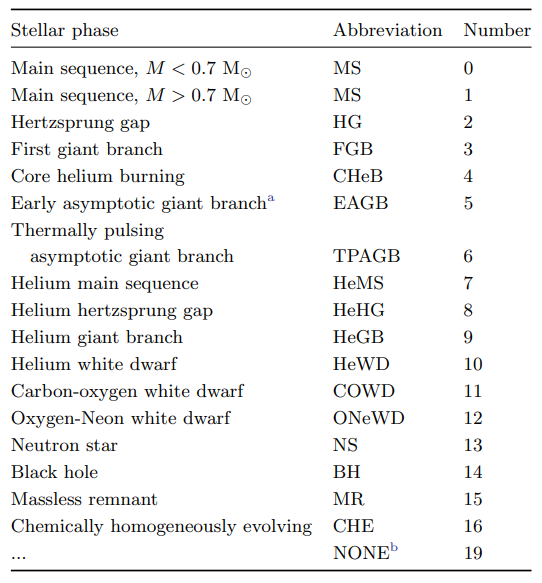

In [169]:
Image("/home/louism/Thesis/COMPAS_stellar_types.png")

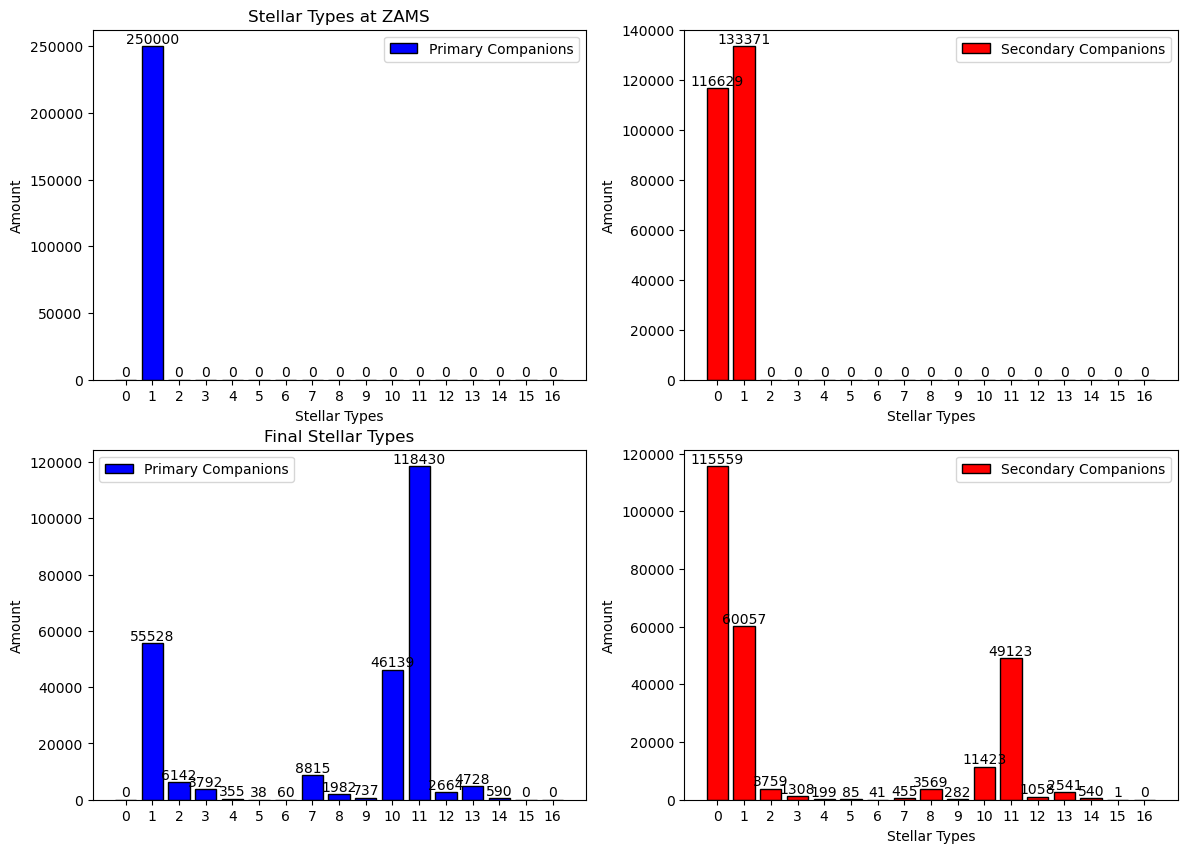

In [170]:
stellar_types_histogram(data)

## Analysis of the different formation channels of sdB binaries

### First CE ejection channel
- Primary (more massive) component experiences dynamical mass transfer on the FGB, leading to CE and spiral-in phase
- Companion is a n MS star
- Product is an sdB in a short period binary with a MS companion
  
Two subchannels:
1) If the initial mass is below helium flash mass (~1.99 solar mass): primary must fill Roche lobe close to tip of FGB in order to ignite helium. The sdB stars from this channel should have masses just below the ciritical core mass for the helium flash. The mass distribution is peaked around 0.46 solar mass and orbital period distribution ranges from 0.05 to around 40 days.
2) If the inital mass is above the helium flash mass: primary must not be close to tip of FGB and can be passing through HG. Envelopes in HG are tighter bound so systems are more likely to merge rather than form sdB stars.

We define masks for the subchannels:
- the stars do not merge
- the primary/secondary is the donor on the FGB (exclusively on FGB) or on the HG (exlusively on HG)
- the companion is an MS star

In [171]:
printCompasDetails(RLOF)
RLOF.keys()

<KeysViewHDF5 ['Beta', 'CEE>MT', 'Eccentricity<MT', 'Eccentricity>MT', 'MT_Event_Counter', 'Mass(1)', 'Mass(1)<MT', 'Mass(1)>MT', 'Mass(2)', 'Mass(2)<MT', 'Mass(2)>MT', 'MassTransferRateDonor', 'Mass_Env(1)', 'Mass_Env(2)', 'Mass_He_Core(1)', 'Mass_He_Core(2)', 'Merger', 'RLOF(1)<MT', 'RLOF(1)>MT', 'RLOF(2)<MT', 'RLOF(2)>MT', 'Radius(1)<MT', 'Radius(1)>MT', 'Radius(1)|RL<step', 'Radius(1)|RL>step', 'Radius(2)<MT', 'Radius(2)>MT', 'Radius(2)|RL<step', 'Radius(2)|RL>step', 'Record_Type', 'SEED', 'SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(1)>MT', 'Stellar_Type(2)<MT', 'Stellar_Type(2)>MT', 'Teff(1)', 'Teff(2)', 'Time<MT', 'Time>MT', 'Zeta_Hurley(1)', 'Zeta_Hurley(2)', 'Zeta_Hurley_He(1)', 'Zeta_Hurley_He(2)', 'Zeta_Soberman(1)', 'Zeta_Soberman(2)', 'Zeta_Soberman_He(1)', 'Zeta_Soberman_He(2)']>

In [172]:
# mask for systems that undergo CE evolution
is_ce = RLOF['CEE>MT'][()]==1

In [173]:
# mask for the donor stars
is_donor1 = (RLOF['RLOF(1)>MT'][()]==1)

is_donor2 = (RLOF['RLOF(2)>MT'][()]==1)

In [174]:
# donor star was on FGB
was_fgb1 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], [3,4])

was_fgb2 = np.in1d(RLOF['Stellar_Type(2)<MT'][()], [3,4])

# donor star was in HG
was_hg1 = np.in1d(RLOF['Stellar_Type(1)<MT'][()], [2])

was_hg2 = np.in1d(RLOF['Stellar_Type(2)<MT'][()], [2])

# donor star is stripped
is_stripped1 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [7,8,9])

is_stripped2 = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [7,8,9])

In [175]:
# companion is an MS star
companion_is_MS1 = np.in1d(RLOF['Stellar_Type(2)>MT'][()], [1,2,16]) & np.in1d(RLOF['Stellar_Type(2)<MT'][()], [1,2,16])

companion_is_MS2 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [1,2,16]) & np.in1d(RLOF['Stellar_Type(1)<MT'][()], [1,2,16])

In [176]:
# stars do not merge
not_merged = (RLOF['Merger'][()]==0)

In [177]:
# additional mask to make sure the star is to some extend stripped of its envelope
has_small_env1 = ((RLOF['Mass(1)'][()]-RLOF['Mass_He_Core(1)'][()])<0.050)
has_small_env2 = ((RLOF['Mass(2)'][()]-RLOF['Mass_He_Core(2)'][()])<0.050)

sdB_mass1 = (RLOF['Mass(1)>MT'][()] < 1.0)
sdB_mass2 = (RLOF['Mass(2)>MT'][()] < 1.0)

In [178]:
# full mask for stars stripped through CE evolution on FGB with MS companion
is_ce_fgb_mscomp1 = is_ce & is_donor1 & was_fgb1 & is_stripped1 & companion_is_MS1 & not_merged & has_small_env1 & sdB_mass1
is_ce_fgb_mscomp2 = is_ce & is_donor2 & was_fgb2 & is_stripped2 & companion_is_MS2 & not_merged & has_small_env2 & sdB_mass2

# full mask for stars stripped through CE evolution in HG with MS companion
is_ce_hg_mscomp1 = is_ce & is_donor1 & was_hg1 & is_stripped1 & companion_is_MS1 & not_merged & has_small_env1 & sdB_mass1
is_ce_hg_mscomp2 = is_ce & is_donor2 & was_hg2 & is_stripped2 & companion_is_MS2 & not_merged & has_small_env2 & sdB_mass2

In [179]:
periods_ce_on_fgb_mscomp = getPeriods(is_ce_fgb_mscomp1, is_ce_fgb_mscomp2)
masses_ce_on_fgb_mscomp = getMasses(is_ce_fgb_mscomp1, is_ce_fgb_mscomp2)

periods_ce_in_hg_mscomp = getPeriods(is_ce_hg_mscomp1, is_ce_hg_mscomp2)
masses_ce_in_hg_mscomp = getMasses(is_ce_hg_mscomp1, is_ce_hg_mscomp2)

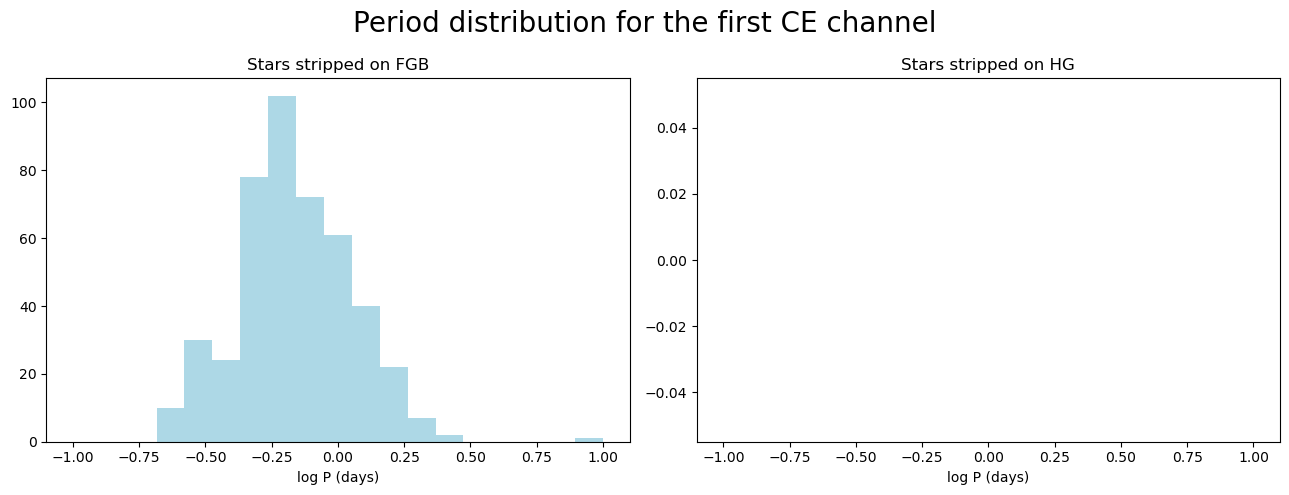

In [180]:
period_bins = np.linspace(-1, 1, 20) 

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(periods_ce_on_fgb_mscomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(periods_ce_in_hg_mscomp, period_bins, color='red')
ax.set_xlabel('log P (days)')

plt.suptitle("Period distribution for the first CE channel", fontsize=20)

plt.tight_layout()

plt.savefig('P_firstCE.png')
plt.show()

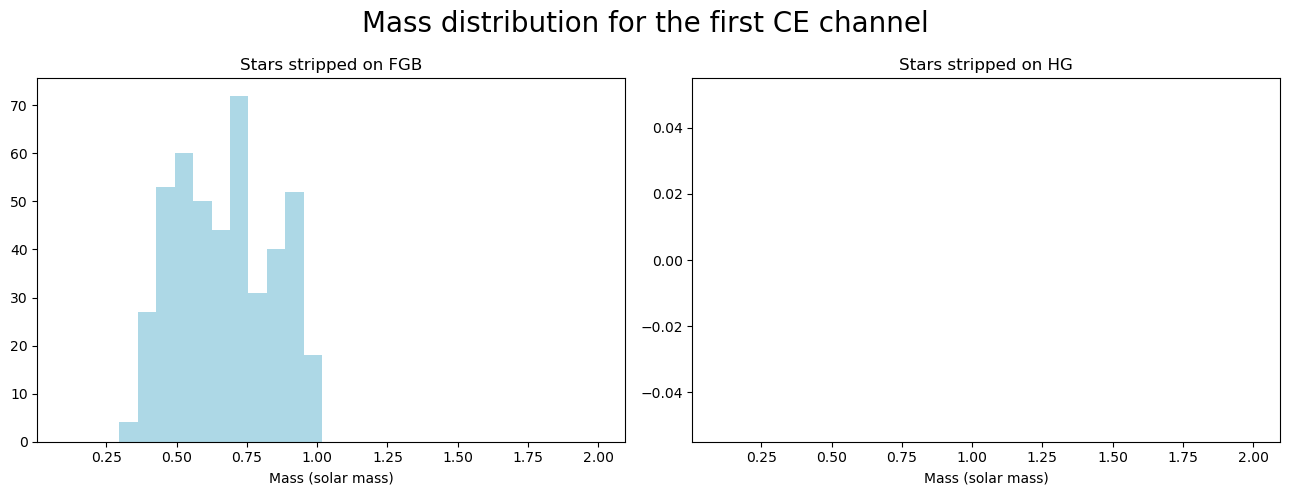

In [181]:
mass_bins = np.linspace(0.1,2,30)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(masses_ce_on_fgb_mscomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(masses_ce_in_hg_mscomp, mass_bins, color='red')
ax.set_xlabel('Mass (solar mass)')

plt.suptitle("Mass distribution for the first CE channel", fontsize=20)

plt.tight_layout()

plt.savefig('M_firstCE.png')
plt.show()

### Second CE ejection channel
- Primary (more massive) component experiences dynamical mass transfer on the FGB, leading to CE and spiral-in phase
- Companion is an WD
- Product is an sdB in a short period binary with a WD companion
  
Two subchannels:
1) If the initial mass is below helium flash mass (~1.99 solar mass): primary must fill Roche lobe close to tip of FGB in order to ignite helium. The sdB stars from this channel should have masses just below the ciritical core mass for the helium flash. The mass distribution is peaked around 0.46 solar mass and orbital period distribution ranges from 0.05 to around 40 days.
2) If the inital mass is above the helium flash mass: primary must not be close to tip of FGB and can be passing through HG. Envelopes in HG are tighter bound so systems are more likely to merge rather than form sdB stars.

We reuse the previous masks and add the WD companion mask:

In [182]:
companion_is_WD1= np.in1d(RLOF['Stellar_Type(2)>MT'][()], [10,11,12]) & np.in1d(RLOF['Stellar_Type(2)<MT'][()], [10,11,12])
companion_is_WD2 = np.in1d(RLOF['Stellar_Type(1)>MT'][()], [10,11,12]) & np.in1d(RLOF['Stellar_Type(1)<MT'][()], [10,11,12])

In [183]:
# full mask for stars stripped through CE evolution on FGB with WD companion
is_ce_fgb_wdcomp1 = is_ce & is_donor1 & was_fgb1 & is_stripped1 & companion_is_WD1 & not_merged & has_small_env1 & sdB_mass1
is_ce_fgb_wdcomp2 = is_ce & is_donor2 & was_fgb2 & is_stripped2 & companion_is_WD2 & not_merged & has_small_env2 & sdB_mass2

# full mask for stars stripped through CE evolution in HG with WD companion
is_ce_hg_wdcomp1 = is_ce & is_donor1 & was_hg1 & is_stripped1 & companion_is_WD1 & not_merged & has_small_env1 & sdB_mass1
is_ce_hg_wdcomp2 = is_ce & is_donor2 & was_hg2 & is_stripped2 & companion_is_WD2 & not_merged & has_small_env2 & sdB_mass2

In [184]:
periods_ce_on_fgb_wdcomp = getPeriods(is_ce_fgb_wdcomp1, is_ce_fgb_wdcomp2)
masses_ce_on_fgb_wdcomp = getMasses(is_ce_fgb_wdcomp1, is_ce_fgb_wdcomp2)

periods_ce_in_hg_wdcomp = getPeriods(is_ce_hg_wdcomp1, is_ce_hg_wdcomp2)
masses_ce_in_hg_wdcomp = getMasses(is_ce_hg_wdcomp1, is_ce_hg_wdcomp2)

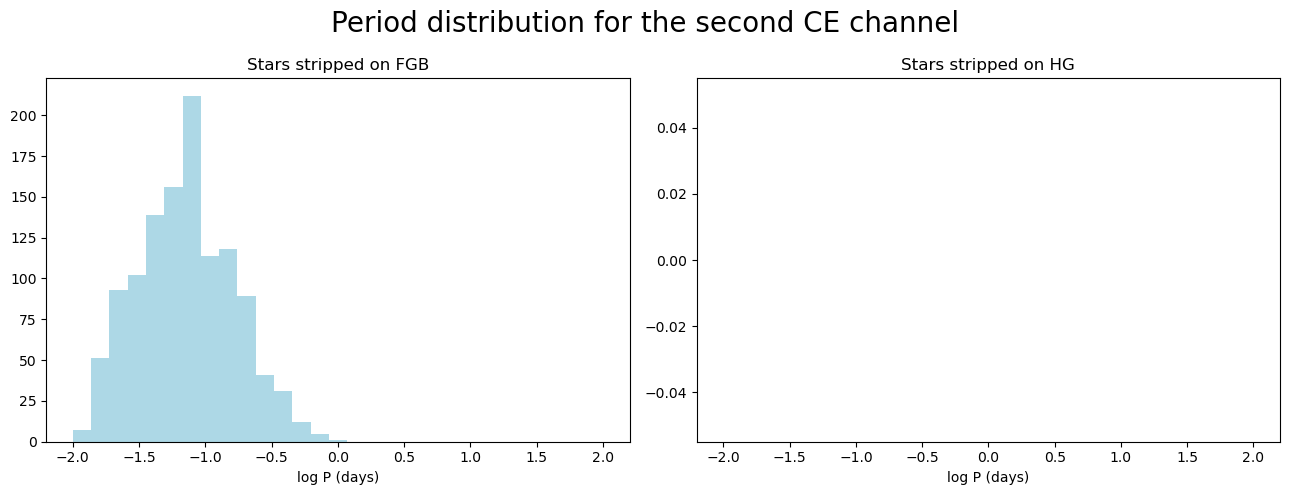

In [185]:
period_bins = np.linspace(-2,2, 30)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(periods_ce_on_fgb_wdcomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(periods_ce_in_hg_wdcomp, period_bins, color='red')
ax.set_xlabel('log P (days)')

plt.suptitle("Period distribution for the second CE channel", fontsize=20)

plt.tight_layout()

plt.savefig('P_secondCE.png')
plt.show()

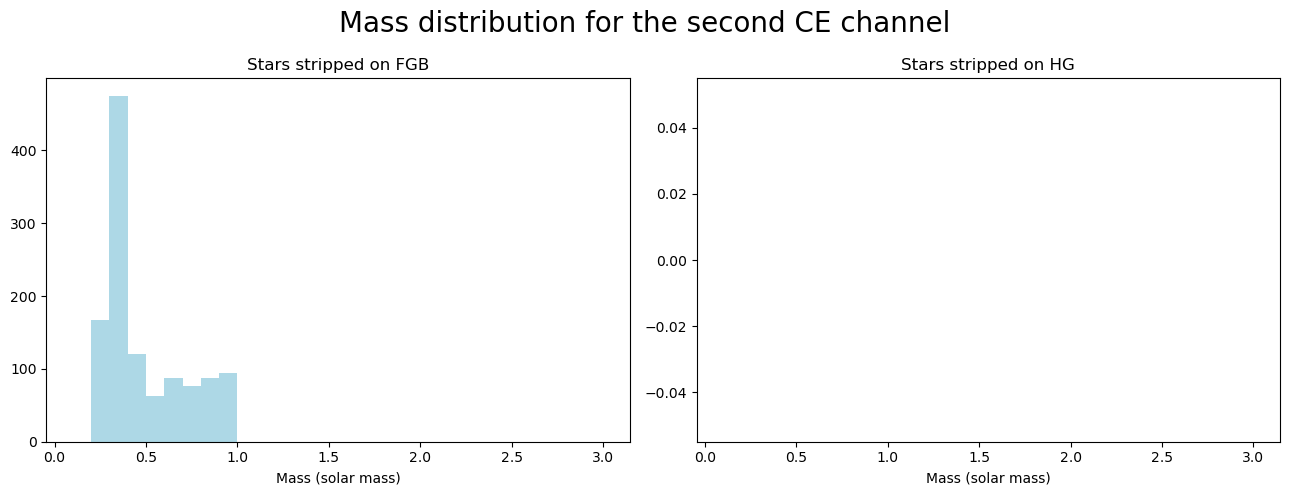

In [186]:
mass_bins = np.linspace(0.1, 3, 30)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(masses_ce_on_fgb_wdcomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(masses_ce_in_hg_wdcomp, mass_bins, color='red')
ax.set_xlabel('Mass (solar mass)')

plt.suptitle("Mass distribution for the second CE channel", fontsize=20)

plt.tight_layout()

plt.savefig('M_secondCE.png')
plt.show()

### First stable RLOF channel
- Primary (more massive) component experiences stable mass transfer and loses envelope
- Shortest orbital periods are the result from angular momentum loss
- Wider mass range from 0.3-1.1 solar mass

Two subchannels
1) ZAMS mass above helium flash mass, RLOF near tip of FGB
2) ZAMS mass below helium flash mass, RLOF can occur in HG (early case B MT)
Wider mass range from 0.3-1.1 solar mass

In [187]:
is_rlof = (RLOF['CEE>MT'][()]==0)

In [188]:
# full mask for stars stripped through RLOF on FGB with MS companion
is_rlof_fgb_mscomp1 = is_rlof & is_donor1 & was_fgb1 & is_stripped1 & companion_is_MS1 & not_merged & has_small_env1 & sdB_mass1
is_rlof_fgb_mscomp2 = is_rlof & is_donor2 & was_fgb2 & is_stripped2 & companion_is_MS2 & not_merged & has_small_env2 & sdB_mass2

# full mask for stars stripped through RLOF in HG with MS companion
is_rlof_hg_mscomp1 = is_rlof & is_donor1 & was_hg1 & is_stripped1 & companion_is_MS1 & not_merged & has_small_env1 & sdB_mass1
is_rlof_hg_mscomp2 = is_rlof & is_donor2 & was_hg2 & is_stripped2 & companion_is_MS2 & not_merged & has_small_env2 & sdB_mass2

In [189]:
periods_rlof_on_fgb_mscomp = getPeriods(is_rlof_fgb_mscomp1, is_rlof_fgb_mscomp2)
masses_rlof_on_fgb_mscomp = getMasses(is_rlof_fgb_mscomp1, is_rlof_fgb_mscomp2)

periods_rlof_in_hg_mscomp = getPeriods(is_rlof_hg_mscomp1, is_rlof_hg_mscomp2)
masses_rlof_in_hg_mscomp = getMasses(is_rlof_hg_mscomp1, is_rlof_hg_mscomp2)

In [190]:
period_bins_rlof = np.linspace(-2, 4, 100)
mass_bins_rlof = np.linspace(0.1, 8, 30)

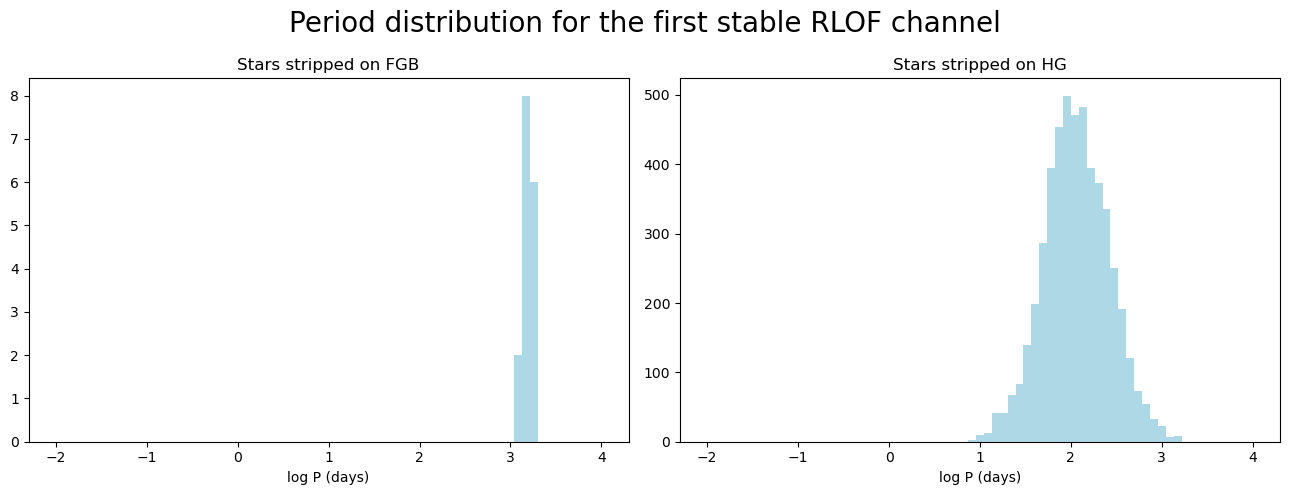

In [191]:
period_bins = np.linspace(-2,4,70)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(periods_rlof_on_fgb_mscomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(periods_rlof_in_hg_mscomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

plt.suptitle("Period distribution for the first stable RLOF channel", fontsize=20)

plt.tight_layout()

plt.savefig('P_firstRLOF.png')
plt.show()

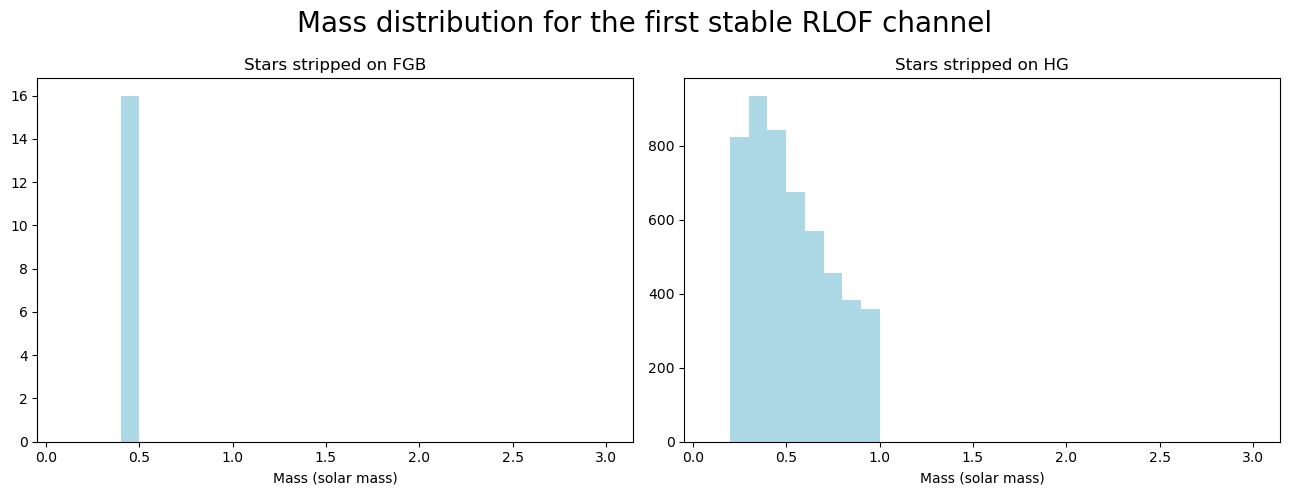

In [192]:
mass_bins = np.linspace(0.1, 3, 30)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(masses_rlof_on_fgb_mscomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(masses_rlof_in_hg_mscomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

plt.suptitle("Mass distribution for the first stable RLOF channel", fontsize=20)

plt.tight_layout()

plt.savefig('M_firstRLOF.png')
plt.show()

### Second stable RLOF channel

In [193]:
# full mask for stars stripped through RLOF on FGB with WD companion
is_rlof_fgb_wdcomp1 = is_rlof & is_donor1 & was_fgb1 & is_stripped1 & companion_is_WD1 & not_merged & has_small_env1 & sdB_mass1
is_rlof_fgb_wdcomp2 = is_rlof & is_donor2 & was_fgb2 & is_stripped2 & companion_is_WD2 & not_merged & has_small_env2 & sdB_mass2

# full mask for stars stripped through RLOF in HG with WD companion 
is_rlof_hg_wdcomp1 = is_rlof & is_donor1 & was_hg1 & is_stripped1 & companion_is_WD1 & not_merged & has_small_env1 & sdB_mass1
is_rlof_hg_wdcomp2 = is_rlof & is_donor2 & was_hg2 & is_stripped2 & companion_is_WD2 & not_merged & has_small_env2 & sdB_mass2

In [194]:
periods_rlof_on_fgb_wdcomp = getPeriods(is_rlof_fgb_wdcomp1, is_rlof_fgb_wdcomp2)
masses_rlof_on_fgb_wdcomp = getMasses(is_rlof_fgb_wdcomp1, is_rlof_fgb_wdcomp2)

periods_rlof_in_hg_wdcomp = getPeriods(is_rlof_hg_wdcomp1, is_rlof_hg_wdcomp2)
masses_rlof_in_hg_wdcomp = getMasses(is_rlof_hg_wdcomp1, is_rlof_hg_wdcomp2)

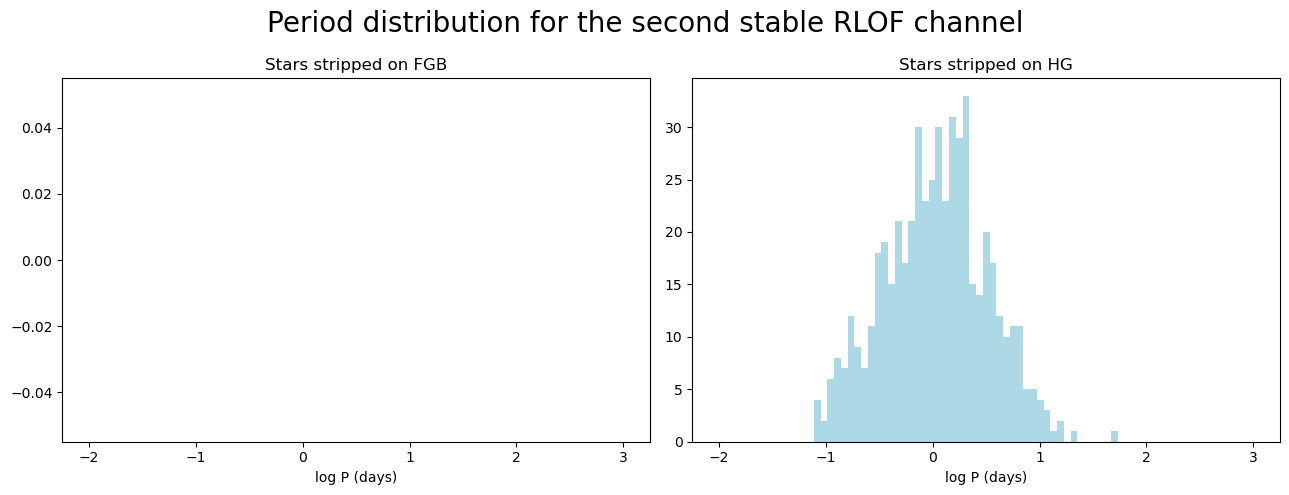

In [195]:
period_bins = np.linspace(-2, 3, 80)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(periods_rlof_on_fgb_wdcomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(periods_rlof_in_hg_wdcomp, period_bins, color='lightblue')
ax.set_xlabel('log P (days)')

plt.suptitle("Period distribution for the second stable RLOF channel", fontsize=20)

plt.tight_layout()

plt.savefig('P_secondRLOF.png')
plt.show()

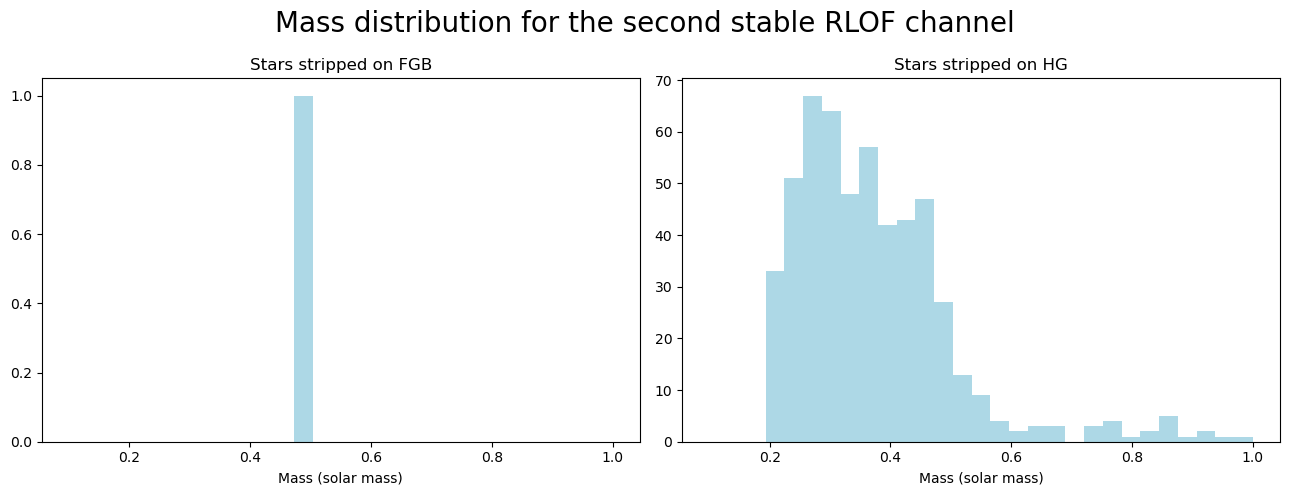

In [196]:
mass_bins = np.linspace(0.1,1, 30)

fig, axes = plt.subplots(1,2, figsize=(13,5))

ax = axes[0]
ax.set_title('Stars stripped on FGB')
ax.hist(masses_rlof_on_fgb_wdcomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

ax = axes[1]
ax.set_title('Stars stripped on HG')
ax.hist(masses_rlof_in_hg_wdcomp, mass_bins, color='lightblue')
ax.set_xlabel('Mass (solar mass)')

plt.suptitle("Mass distribution for the second stable RLOF channel", fontsize=20)

plt.tight_layout()

plt.savefig('M_secondRLOF.png')
plt.show()

## Time spent as a stripped star for the different formation channel
For the function to work we add an additional mask to single out the systems that have evolved to an CO:

In [197]:
has_fully_evolved1 = np.in1d(SPs['Stellar_Type(1)'][()], [10,11,12,13,14,15,16,19])
has_fully_evolved2 = np.in1d(SPs['Stellar_Type(2)'][()], [10,11,12,13,14,15,16,19])

We define the function that is used to get the time the star spent as a stripped star for the stars that have evolved into COs. 
Additionally, we add the sdB mass and the type of the star before and after stripping to the output as well.

In [198]:
def getMassVsTimeStripped(channel_mask, primary_or_secondary):
    if (primary_or_secondary==1):
        
        in_channel_and_evolved = np.in1d(SLs['SEED'][()], RLOF['SEED'][channel_mask]) & np.in1d(SLs['SEED'][()], SPs['SEED'][has_fully_evolved1])
        has_evolved = np.in1d(RLOF['SEED'][()], SPs['SEED'][has_fully_evolved1])
        
        stripped = in_channel_and_evolved & (SLs['Star_Switching'][()]==1) & \
        np.in1d(SLs['Switching_From'][()], [2,3,4,5]) & np.in1d(SLs['Switching_To'][()], [7,8,9])
        
        compact_object = in_channel_and_evolved & (SLs['Star_Switching'][()]==1) & \
        np.in1d(SLs['Switching_From'][()], [7,8,9]) & np.in1d(SLs['Switching_To'][()], [10,11,12,13,14,15,16,19])

        time_spent_stripped = SLs['Time'][compact_object] - SLs['Time'][stripped]
        sdB_mass = RLOF['Mass(1)>MT'][channel_mask&has_evolved]
        stripped_as = SLs['Switching_From'][stripped]
        stripped_to = SLs['Switching_To'][stripped]
        #zams_mass = RLOF['Mass@ZAMS(1)'][channel_mask&has_evolved] 
        mass_pre_stripping = RLOF['Mass(1)<MT'][channel_mask&has_evolved] 
        mass_he_core = RLOF['Mass_He_Core(1)'][channel_mask&has_evolved]
        mass_ratio = (RLOF['Mass(1)>MT'][channel_mask&has_evolved]/RLOF['Mass(2)>MT'][channel_mask&has_evolved])
        log_period = logPeriod(channel_mask&has_evolved)
        
    if (primary_or_secondary==2):
        
        in_channel_and_evolved = np.in1d(SLs['SEED'][()], RLOF['SEED'][channel_mask]) & np.in1d(SLs['SEED'][()], SPs['SEED'][has_fully_evolved2])
        has_evolved = np.in1d(RLOF['SEED'][()], SPs['SEED'][has_fully_evolved2])
        
        stripped = in_channel_and_evolved & (SLs['Star_Switching'][()]==2) & \
        np.in1d(SLs['Switching_From'][()], [2,3,4,5]) & np.in1d(SLs['Switching_To'][()], [7,8,9])
        
        compact_object = in_channel_and_evolved & (SLs['Star_Switching'][()]==2) & \
        np.in1d(SLs['Switching_From'][()], [7,8,9]) & np.in1d(SLs['Switching_To'][()], [10,11,12,13,14,15,16,19])

        time_spent_stripped = SLs['Time'][compact_object] - SLs['Time'][stripped]
        sdB_mass = RLOF['Mass(2)>MT'][channel_mask&has_evolved]
        stripped_as = SLs['Switching_From'][stripped]
        stripped_to = SLs['Switching_To'][stripped]
        #zams_mass = RLOF['Mass@ZAMS(2)'][channel_mask&has_evolved] 
        mass_pre_stripping = RLOF['Mass(2)<MT'][channel_mask&has_evolved] 
        mass_he_core = RLOF['Mass_He_Core(2)'][channel_mask&has_evolved]
        mass_ratio = (RLOF['Mass(2)>MT'][channel_mask&has_evolved]/RLOF['Mass(1)>MT'][channel_mask&has_evolved])
        log_period = logPeriod(channel_mask&has_evolved)
    
    return [sdB_mass, time_spent_stripped, stripped_as, stripped_to, mass_pre_stripping, mass_he_core, mass_ratio, log_period]

We combine the masks defined above for the different subchannel to get the full channel mask but keep the distinction between primary and secondary stars.

In [199]:
from_first_ce1 = is_ce_fgb_mscomp1 | is_ce_hg_mscomp1 
from_second_ce1 = is_ce_fgb_wdcomp1 | is_ce_hg_wdcomp1

from_first_ce2 = is_ce_fgb_mscomp2 | is_ce_hg_mscomp2
from_second_ce2 = is_ce_fgb_wdcomp2 | is_ce_hg_wdcomp2

In [200]:
from_first_rlof1 = is_rlof_fgb_mscomp1 | is_rlof_hg_mscomp1 
from_second_rlof1 = is_rlof_fgb_wdcomp1 | is_rlof_hg_wdcomp1 

from_first_rlof2 = is_rlof_fgb_mscomp2 | is_rlof_hg_mscomp2
from_second_rlof2 = is_rlof_fgb_wdcomp2 | is_rlof_hg_wdcomp2

We apply the function and plot the results.

In [201]:
to_plot_first_ce1 = getMassVsTimeStripped(from_first_ce1, 1)

In [202]:
to_plot_first_ce2 = getMassVsTimeStripped(from_first_ce2, 2)

In [203]:
to_plot_second_ce1 = getMassVsTimeStripped(from_second_ce1, 1)

In [204]:
to_plot_second_ce2 = getMassVsTimeStripped(from_second_ce2, 2)

In [205]:
to_plot_first_rlof1 = getMassVsTimeStripped(from_first_rlof1, 1)

In [206]:
to_plot_first_rlof2 = getMassVsTimeStripped(from_first_rlof2, 2)

In [207]:
to_plot_second_rlof1 = getMassVsTimeStripped(from_second_rlof1, 1)

In [208]:
to_plot_second_rlof2 = getMassVsTimeStripped(from_second_rlof2, 2)

In [209]:
stripped_as_shapes = {2 : 's',
                      3 : 'd',
                      4 : 'o',
                      5 : '<'
                     }

In [210]:
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='CE+MS', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='RLOF+MS', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='CE+WD', markerfacecolor='yellow', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='RLOF+WD', markerfacecolor='green', markersize=10),
    
    plt.Line2D([0], [0], marker='s', color='w', label='Stripped in HG', markerfacecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='d', color='w', label='Stripped on FGB', markerfacecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Stripped as CHeB', markerfacecolor='black', markersize=10)
]

In [136]:
fig, axes = plt.subplots(1,2, figsize=(14,8))

plt.suptitle("Time spent as a stripped star as a function of sdB mass")

ax = axes[0]
for i in range(len(to_plot_first_ce1[0])):
    ax.scatter(to_plot_first_ce1[5][i], to_plot_first_ce1[1][i], 
               color='red',
               marker=stripped_as_shapes[to_plot_first_ce1[2][i]], 
               s=10)

for i in range(len(to_plot_second_ce1[0])):
    ax.scatter(to_plot_second_ce1[5][i], to_plot_second_ce1[1][i], 
               color=stripped_to_colors[to_plot_second_ce1[3][i]],
               marker=stripped_as_shapes[to_plot_second_ce1[2][i]], 
               s=10)

for i in range(len(to_plot_first_rlof1[0])):
    ax.scatter(to_plot_first_rlof1[5][i], to_plot_first_rlof1[1][i], 
               color='blue',
               marker=stripped_as_shapes[to_plot_first_rlof1[2][i]], 
               s=10)

for i in range(len(to_plot_second_rlof1[0])):
    ax.scatter(to_plot_second_rlof1[5][i], to_plot_second_rlof1[1][i], 
               color=stripped_to_colors[to_plot_second_rlof1[3][i]],
               marker=stripped_as_shapes[to_plot_second_rlof1[2][i]], 
               s=10)

ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars')
ax.set_xlabel('Mass Post-Stripping (solar mass)')
ax.set_ylabel('He Burning Lifetime (Myr)')
ax.legend(handles=legend_elements, loc='best', fontsize=10)

ax = axes[1]
for i in range(len(to_plot_first_ce2[0])):
    ax.scatter(to_plot_first_ce2[5][i], to_plot_first_ce2[1][i], 
               color='red',
               marker=stripped_as_shapes[to_plot_first_ce2[2][i]], 
               s=10)

for i in range(len(to_plot_second_ce2[0])):
    ax.scatter(to_plot_second_ce2[5][i], to_plot_second_ce2[1][i], 
               color='yellow',
               marker=stripped_as_shapes[to_plot_second_ce2[2][i]], 
               s=10)

for i in range(len(to_plot_first_rlof2[0])):
    ax.scatter(to_plot_first_rlof2[5][i], to_plot_first_rlof2[1][i], 
               color='blue',
               marker=stripped_as_shapes[to_plot_first_rlof2[2][i]], 
               s=10)

for i in range(len(to_plot_second_rlof2[0])):
    ax.scatter(to_plot_second_rlof2[5][i], to_plot_second_rlof2[1][i], 
               color='green',
               marker=stripped_as_shapes[to_plot_second_rlof2[2][i]], 
               s=10)

ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars')
ax.set_xlabel('Mass Post-Stripping (solar mass)')
ax.set_ylabel('He Burning Lifetime (Myr)')
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.show()

KeyboardInterrupt: 

In [211]:
legend_1 = [
            plt.Line2D([0], [0], marker='o', color='w', label='CE+MS', markerfacecolor='black', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='RLOF+MS', markerfacecolor='red', markersize=10),
            ]
legend_2 = [
            plt.Line2D([0], [0], marker='o', color='w', label='CE+WD', markerfacecolor='black', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='RLOF+WD', markerfacecolor='red', markersize=10),
            ]


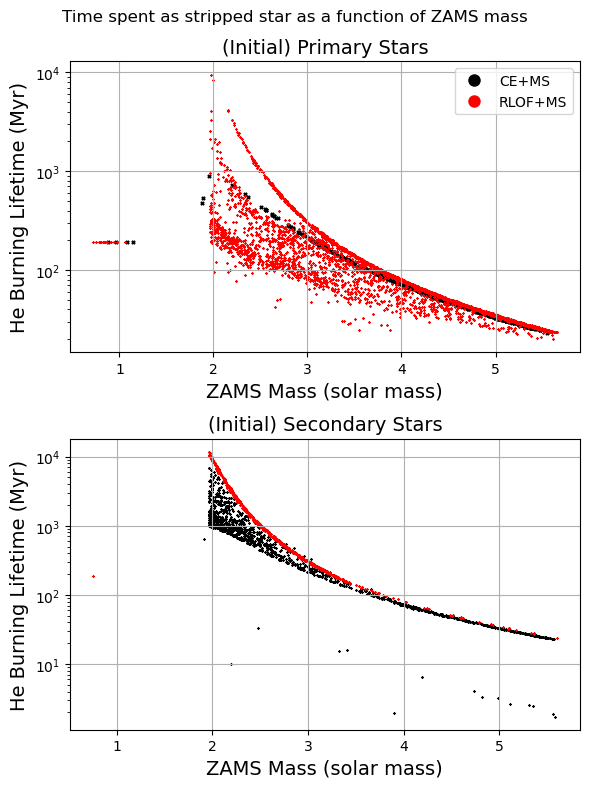

In [212]:
fig, axes = plt.subplots(2,1, figsize=(6,8))

plt.suptitle("Time spent as stripped star as a function of ZAMS mass")

ax = axes[0]
ax.scatter(to_plot_first_ce1[4], to_plot_first_ce1[1], color='black', marker = 'x', s=5, label='CE+MS')
ax.scatter(to_plot_second_ce1[4], to_plot_second_ce1[1], color='yellow', marker = 'x', s=1, alpha=0.7)
ax.scatter(to_plot_first_rlof1[4], to_plot_first_rlof1[1], color='red', marker = 'x', s=1, label='RLOF+MS')
ax.scatter(to_plot_second_rlof1[4], to_plot_second_rlof1[1], color='blue', marker = 'x', s=1, alpha=0.7)

ax.grid()
ax.legend(handles=legend_1)
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('ZAMS Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
ax.scatter(to_plot_first_ce2[4], to_plot_first_ce2[1], color='yellow', marker = 'x', s=10, alpha=0.2)
ax.scatter(to_plot_second_ce2[4], to_plot_second_ce2[1], color='black', marker = 'x', s=1, label='CE+WD')
ax.scatter(to_plot_first_rlof2[4], to_plot_first_rlof2[1], color='blue', marker = 'x', s=10, alpha=0.7)
ax.scatter(to_plot_second_rlof2[4], to_plot_second_rlof2[1], color='red', marker = 'x', s=1, label='RLOF+WD')

ax.grid()
#ax.legend(handles=legend_2)
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('ZAMS Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.tight_layout()
#plt.savefig("Mzams_vs_time.png", dpi=420)
plt.show()

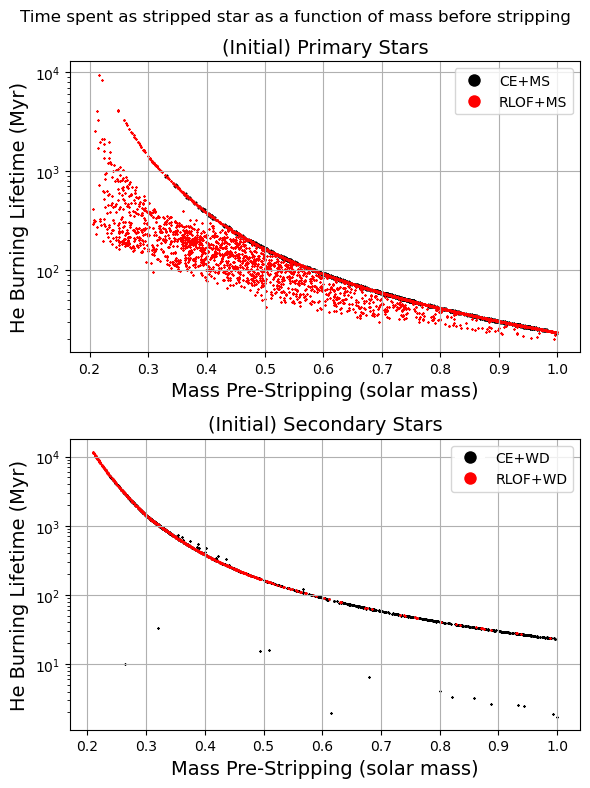

In [213]:
fig, axes = plt.subplots(2,1, figsize=(6,8))

plt.suptitle("Time spent as stripped star as a function of mass before stripping")

ax = axes[0]
ax.scatter(to_plot_first_ce1[5], to_plot_first_ce1[1], color='black', marker = 'x', s=5, label='CE+MS')
#ax.scatter(to_plot_second_ce1[5], to_plot_second_ce1[1], color='yellow', marker = 'x', s=1, alpha=0.7)
ax.scatter(to_plot_first_rlof1[5], to_plot_first_rlof1[1], color='red', marker = 'x', s=1, label='RLOF+MS')
#ax.scatter(to_plot_second_rlof1[5], to_plot_second_rlof1[1], color='blue', marker = 'x', s=1, alpha=0.7)

ax.grid()
ax.legend(handles=legend_1)
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('Mass Pre-Stripping (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
#ax.scatter(to_plot_first_ce2[5], to_plot_first_ce2[1], color='black', marker = 'x', s=10, alpha=0.2)
ax.scatter(to_plot_second_ce2[5], to_plot_second_ce2[1], color='black', marker = 'x', s=1, label='CE+WD')
#ax.scatter(to_plot_first_rlof2[5], to_plot_first_rlof2[1], color='red', marker = 'x', s=10, alpha=0.7)
ax.scatter(to_plot_second_rlof2[5], to_plot_second_rlof2[1], color='red', marker = 'x', s=1, label='RLOF+WD')

ax.grid()
ax.legend(handles=legend_2)
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('Mass Pre-Stripping (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.tight_layout()
#plt.savefig("Mprestripping_vs_time.png", dpi=420)
plt.show()

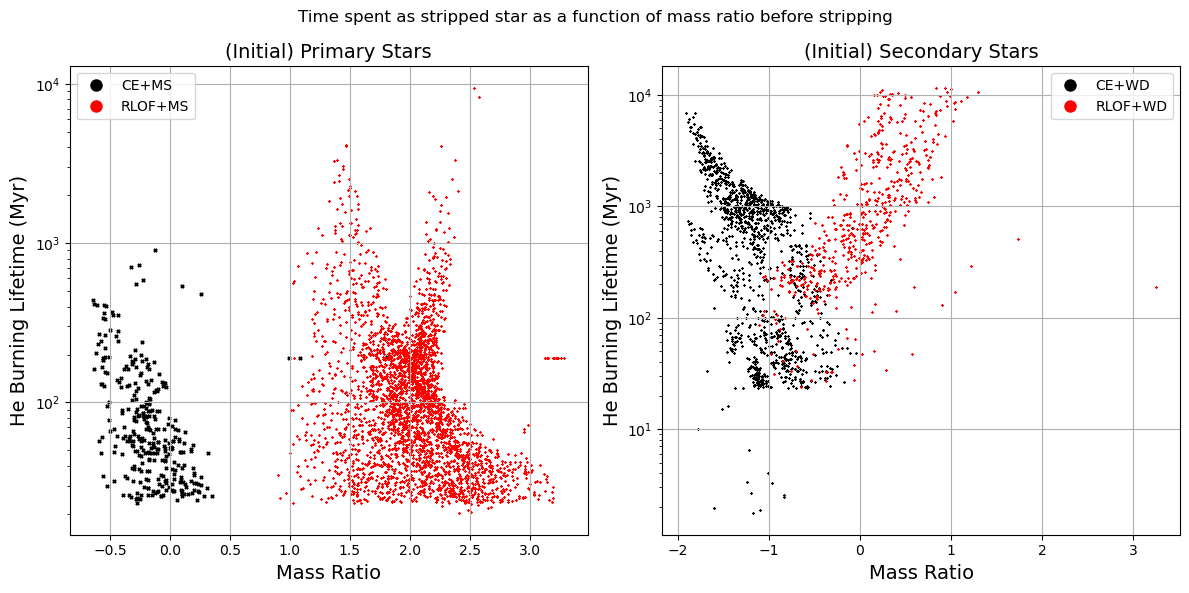

In [214]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Time spent as stripped star as a function of mass ratio before stripping")

ax = axes[0]
ax.scatter(to_plot_first_ce1[7], to_plot_first_ce1[1], color='black', marker = 'x', s=5, label='CE+MS')
#ax.scatter(to_plot_second_ce1[7], to_plot_second_ce1[1], color='yellow', marker = 'x', s=1, alpha=0.7)
ax.scatter(to_plot_first_rlof1[7], to_plot_first_rlof1[1], color='red', marker = 'x', s=1, label='RLOF+MS')
#ax.scatter(to_plot_second_rlof1[7], to_plot_second_rlof1[1], color='blue', marker = 'x', s=1, alpha=0.7)

ax.grid()
ax.legend(handles=legend_1)
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('Mass Ratio', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
#ax.scatter(to_plot_first_ce2[7], to_plot_first_ce2[1], color='black', marker = 'x', s=10, alpha=0.2)
ax.scatter(to_plot_second_ce2[7], to_plot_second_ce2[1], color='black', marker = 'x', s=1, label='CE+WD')
#ax.scatter(to_plot_first_rlof2[7], to_plot_first_rlof2[1], color='red', marker = 'x', s=10, alpha=0.7)
ax.scatter(to_plot_second_rlof2[7], to_plot_second_rlof2[1], color='red', marker = 'x', s=1, label='RLOF+WD')

ax.grid()
ax.legend(handles=legend_2)
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('Mass Ratio', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.tight_layout()
#plt.savefig("Mratio_vs_time.png", dpi=420)
plt.show()

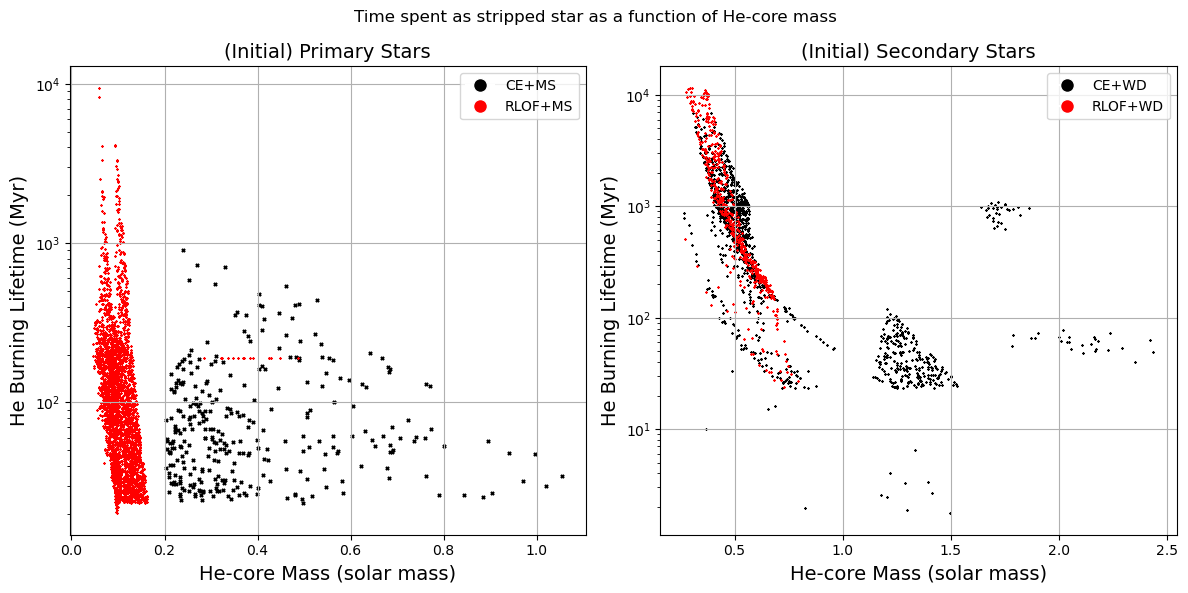

In [215]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Time spent as stripped star as a function of He-core mass")

ax = axes[0]
ax.scatter(to_plot_first_ce1[6], to_plot_first_ce1[1], color='black', marker = 'x', s=5, label='CE+MS')
#ax.scatter(to_plot_second_ce1[6], to_plot_second_ce1[1], color='yellow', marker = 'x', s=1, alpha=0.7)
ax.scatter(to_plot_first_rlof1[6], to_plot_first_rlof1[1], color='red', marker = 'x', s=1, label='RLOF+MS')
#ax.scatter(to_plot_second_rlof1[6], to_plot_second_rlof1[1], color='blue', marker = 'x', s=1, alpha=0.7)

ax.grid()
ax.legend(handles=legend_1)
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('He-core Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
#ax.scatter(to_plot_first_ce2[6], to_plot_first_ce2[1], color='black', marker = 'x', s=10, alpha=0.2)
ax.scatter(to_plot_second_ce2[6], to_plot_second_ce2[1], color='black', marker = 'x', s=1, label='CE+WD')
#ax.scatter(to_plot_first_rlof2[6], to_plot_first_rlof2[1], color='red', marker = 'x', s=10, alpha=0.7)
ax.scatter(to_plot_second_rlof2[6], to_plot_second_rlof2[1], color='red', marker = 'x', s=1, label='RLOF+WD')

ax.grid()
ax.legend(handles=legend_2)
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('He-core Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.tight_layout()
#plt.savefig("MsdB_vs_time.png", dpi=420)
plt.show()

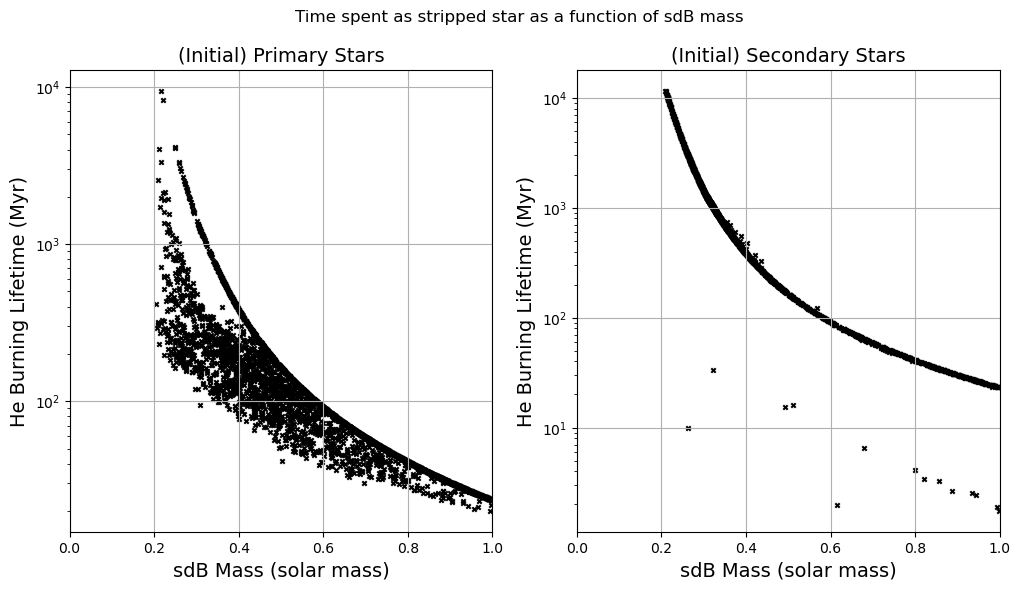

In [216]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Time spent as stripped star as a function of sdB mass")

ax = axes[0]
ax.scatter(to_plot_first_ce1[0], to_plot_first_ce1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_ce1[0], to_plot_second_ce1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_first_rlof1[0], to_plot_first_rlof1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_rlof1[0], to_plot_second_rlof1[1], color='black', marker = 'x', s=10)

ax.set_xlim(0,1)
ax.grid()
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('sdB Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
ax.scatter(to_plot_first_ce2[0], to_plot_first_ce2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_ce2[0], to_plot_second_ce2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_first_rlof2[0], to_plot_first_rlof2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_rlof2[0], to_plot_second_rlof2[1], color='black', marker = 'x', s=10)

ax.set_xlim(0,1)
ax.grid()
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('sdB Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.show()

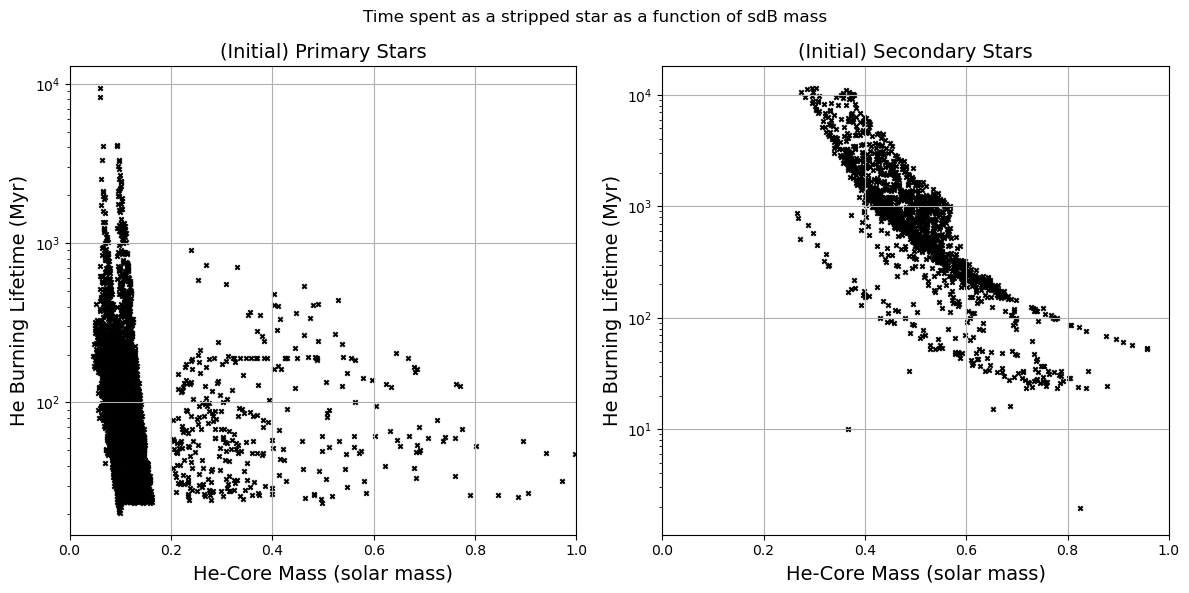

In [217]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Time spent as a stripped star as a function of sdB mass")

ax = axes[0]
ax.scatter(to_plot_first_ce1[6], to_plot_first_ce1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_ce1[6], to_plot_second_ce1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_first_rlof1[6], to_plot_first_rlof1[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_rlof1[6], to_plot_second_rlof1[1], color='black', marker = 'x', s=10)

ax.set_xlim(0,1)
ax.grid()
ax.set_yscale('log')
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('He-Core Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

ax = axes[1]
ax.scatter(to_plot_first_ce2[6], to_plot_first_ce2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_ce2[6], to_plot_second_ce2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_first_rlof2[6], to_plot_first_rlof2[1], color='black', marker = 'x', s=10)
ax.scatter(to_plot_second_rlof2[6], to_plot_second_rlof2[1], color='black', marker = 'x', s=10)

ax.set_xlim(0,1)
ax.grid()
ax.set_yscale('log')
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('He-Core Mass (solar mass)', fontsize=14)
ax.set_ylabel('He Burning Lifetime (Myr)', fontsize=14)

plt.tight_layout()
#plt.savefig('He_core_mass_vs_time.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


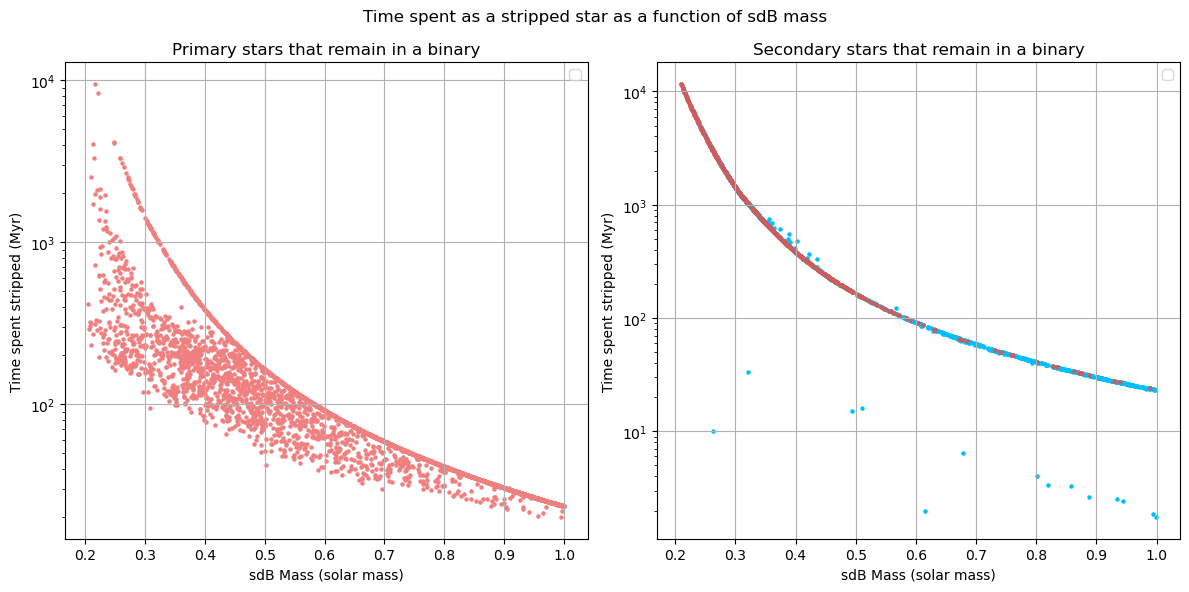

In [218]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Time spent as a stripped star as a function of sdB mass")

ax = axes[0]

ax.scatter(to_plot_first_ce1[0], to_plot_first_ce1[1], color='lightblue', s=5)
ax.scatter(to_plot_second_ce1[0], to_plot_second_ce1[1], color='deepskyblue', s=5)
ax.scatter(to_plot_first_rlof1[0], to_plot_first_rlof1[1], color='lightcoral', s=5)
ax.scatter(to_plot_second_rlof1[0], to_plot_second_rlof1[1], color='indianred', s=5)

ax.set_title('Primary stars that remain in a binary') 
ax.set_xlabel('sdB Mass (solar mass)')
ax.set_ylabel('Time spent stripped (Myr)')
ax.legend(loc='best')
ax.set_yscale('log')
ax.grid()

ax = axes[1]
ax.scatter(to_plot_first_ce2[0], to_plot_first_ce2[1], color='lightblue', s=5)
ax.scatter(to_plot_second_ce2[0], to_plot_second_ce2[1], color='deepskyblue', s=5)
ax.scatter(to_plot_first_rlof2[0], to_plot_first_rlof2[1], color='lightcoral', s=5)
ax.scatter(to_plot_second_rlof2[0], to_plot_second_rlof2[1], color='indianred', s=5)

ax.set_title('Secondary stars that remain in a binary')
ax.set_xlabel('sdB Mass (solar mass)')
ax.set_ylabel('Time spent stripped (Myr)')
ax.legend(loc='best')
ax.set_yscale('log')
ax.grid()

plt.tight_layout()

#plt.savefig('TimeSpentStripped.png')
plt.show()

## Teff-Logg Plots

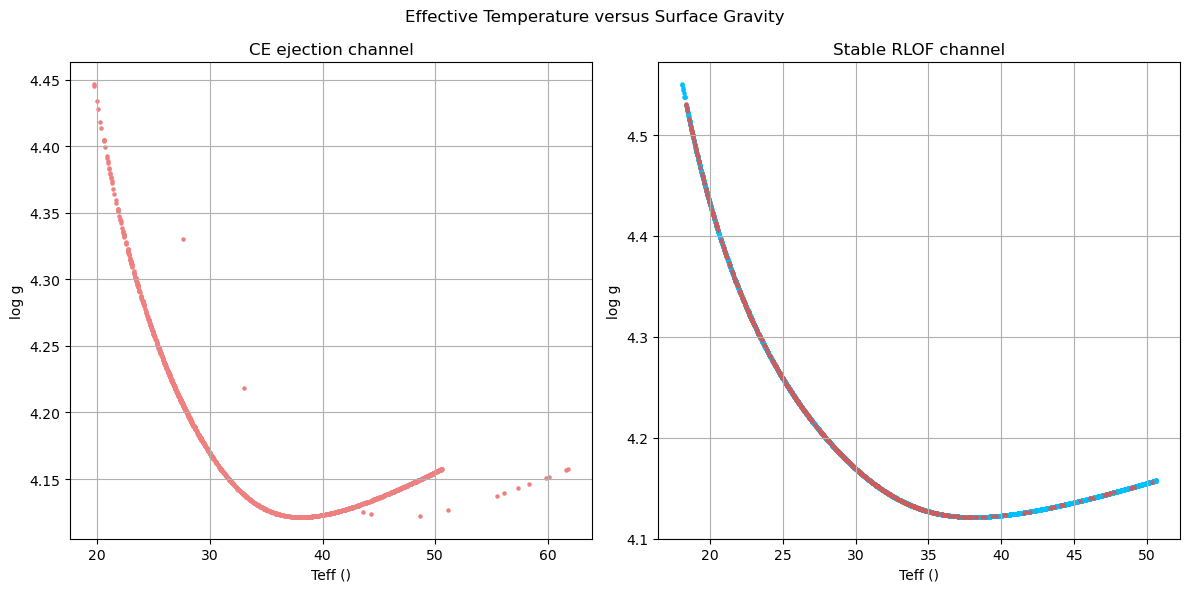

In [219]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

plt.suptitle("Effective Temperature versus Surface Gravity")

ax = axes[0]

ax.scatter(getEffectiveTemperature(is_ce_fgb_mscomp1, is_ce_fgb_mscomp2), getSurfaceGravity(is_ce_fgb_mscomp1, is_ce_fgb_mscomp2), color='lightblue', s=5)
ax.scatter(getEffectiveTemperature(is_ce_hg_mscomp1, is_ce_hg_mscomp2), getSurfaceGravity(is_ce_hg_mscomp1, is_ce_hg_mscomp2), color='deepskyblue', s=5)
ax.scatter(getEffectiveTemperature(is_ce_fgb_wdcomp1, is_ce_fgb_wdcomp2), getSurfaceGravity(is_ce_fgb_wdcomp1, is_ce_fgb_wdcomp2), color='lightcoral', s=5)
ax.scatter(getEffectiveTemperature(is_ce_hg_wdcomp1, is_ce_hg_wdcomp2), getSurfaceGravity(is_ce_hg_wdcomp1, is_ce_hg_wdcomp2), color='indianred', s=5)

ax.set_title('CE ejection channel') 
ax.set_xlabel('Teff ()')
ax.set_ylabel('log g')
ax.grid()

ax = axes[1]
ax.scatter(getEffectiveTemperature(is_rlof_fgb_mscomp1, is_rlof_fgb_mscomp2), getSurfaceGravity(is_rlof_fgb_mscomp1, is_rlof_fgb_mscomp2), color='lightblue', s=5)
ax.scatter(getEffectiveTemperature(is_rlof_hg_mscomp1, is_rlof_hg_mscomp2), getSurfaceGravity(is_rlof_hg_mscomp1, is_rlof_hg_mscomp2), color='deepskyblue', s=5)
ax.scatter(getEffectiveTemperature(is_rlof_fgb_wdcomp1, is_rlof_fgb_wdcomp2), getSurfaceGravity(is_rlof_fgb_wdcomp1, is_rlof_fgb_wdcomp2), color='lightcoral', s=5)
ax.scatter(getEffectiveTemperature(is_rlof_hg_wdcomp1, is_rlof_hg_wdcomp2), getSurfaceGravity(is_rlof_hg_wdcomp1, is_rlof_hg_wdcomp2), color='indianred', s=5)


ax.set_title('Stable RLOF channel')
ax.set_xlabel('Teff ()')
ax.set_ylabel('log g')
ax.grid()

plt.tight_layout()

In [220]:
masses1 = [to_plot_first_ce1[0], to_plot_first_rlof1[0]]
masses2 = [to_plot_second_ce2[0], to_plot_second_rlof2[0]]

periods1 = [to_plot_first_ce1[7], to_plot_first_rlof1[7]]
periods2 = [to_plot_second_ce2[7], to_plot_second_rlof2[7]]

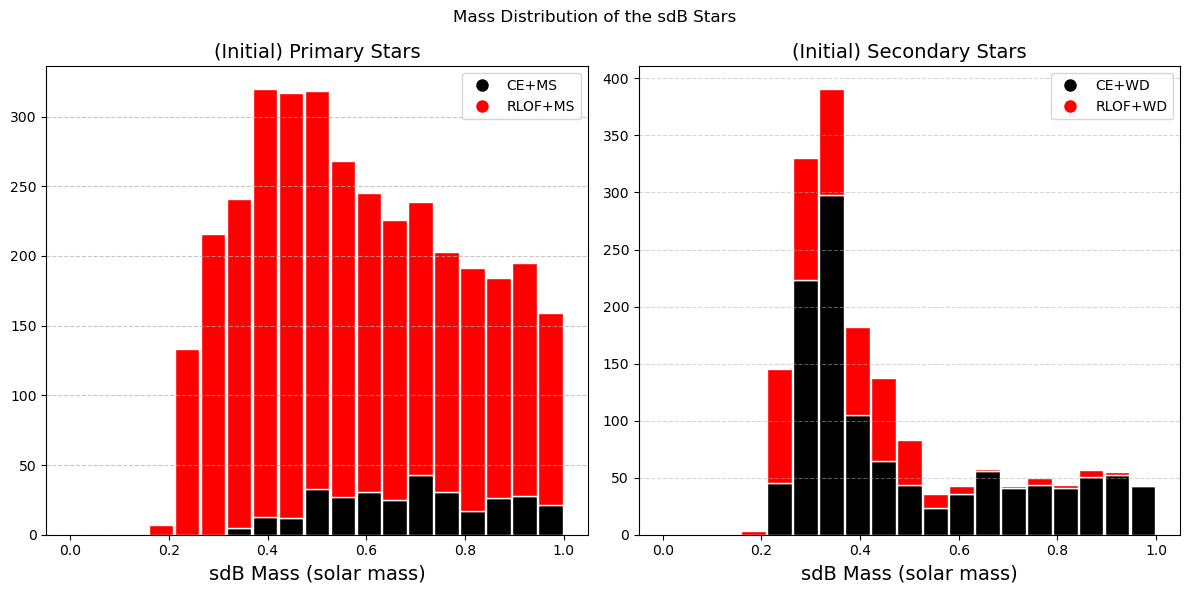

In [221]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

bins = np.linspace(0,1,20)

ax=axes[0]
ax.hist(masses1, bins=bins, color=['black', 'red'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(handles=legend_1)
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('sdB Mass (solar mass)', fontsize=14)


ax=axes[1]
ax.hist(masses2, bins=bins, color=['black', 'red'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(handles=legend_2)
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('sdB Mass (solar mass)', fontsize=14)

plt.suptitle('Mass Distribution of the sdB Stars')
plt.tight_layout()
plt.savefig('Mass_distribution.png', dpi=420)
plt.show()

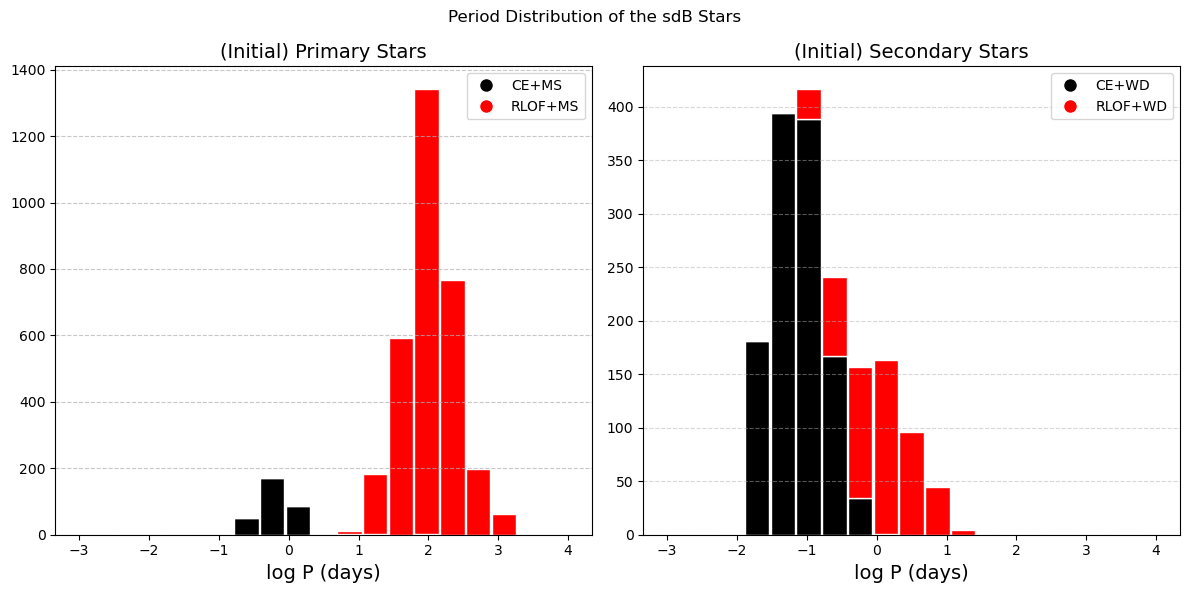

In [222]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

bins = np.linspace(-3,4,20)

ax=axes[0]
ax.hist(periods1, bins=bins, color=['black', 'red'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(handles=legend_1)
ax.set_title('(Initial) Primary Stars', fontsize=14)
ax.set_xlabel('log P (days)', fontsize=14)

ax=axes[1]
ax.hist(periods2, bins=bins, color=['black', 'red'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(handles=legend_2)
ax.set_title('(Initial) Secondary Stars', fontsize=14)
ax.set_xlabel('log P (days)', fontsize=14)

plt.suptitle('Period Distribution of the sdB Stars')
plt.tight_layout()
plt.savefig('Period_Distribution.png', dpi=420)
plt.show()

In [223]:
legend_3 = [
            plt.Line2D([0], [0], marker='o', color='w', label='CE+MS', markerfacecolor='black', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='RLOF+MS', markerfacecolor='red', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='CE+WD', markerfacecolor='grey', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='RLOF+WD', markerfacecolor='coral', markersize=10)
            ]

In [224]:
all_periods = [to_plot_first_ce1[7], to_plot_first_rlof1[7], to_plot_second_ce2[7], to_plot_second_rlof2[7]]
all_masses = [to_plot_first_ce1[0], to_plot_first_rlof1[0], to_plot_second_ce2[0], to_plot_second_rlof2[0]]

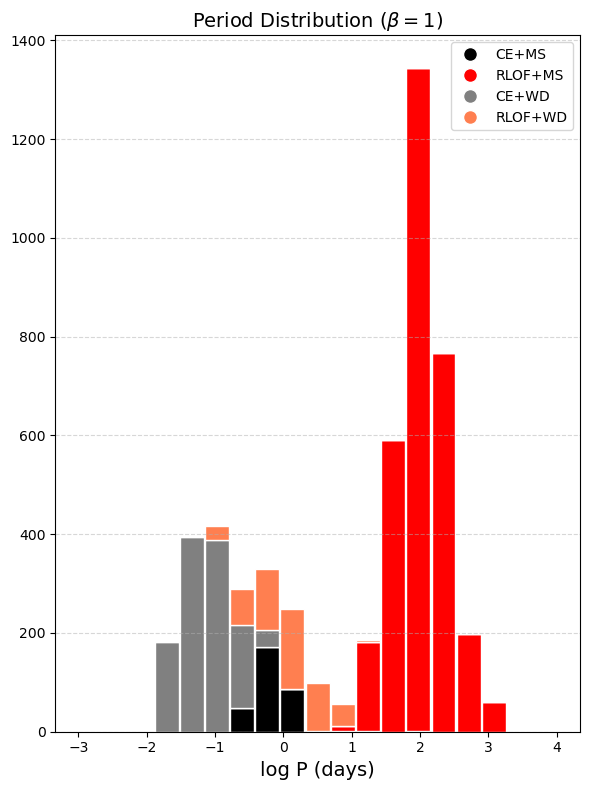

In [225]:
fig, axes = plt.subplots(1,1, figsize=(6,8))

bins = np.linspace(-3,4,20)

ax=axes
ax.hist(all_periods, bins=bins, color=['black', 'red', 'grey', 'coral'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.5)

ax.set_title(r'Period Distribution ($\beta =1$)', fontsize=14)
ax.set_xlabel('log P (days)', fontsize=14)
ax.legend(handles=legend_3)

plt.tight_layout()
plt.savefig('Period_Distribution_beta1.png', dpi=420)
plt.show()

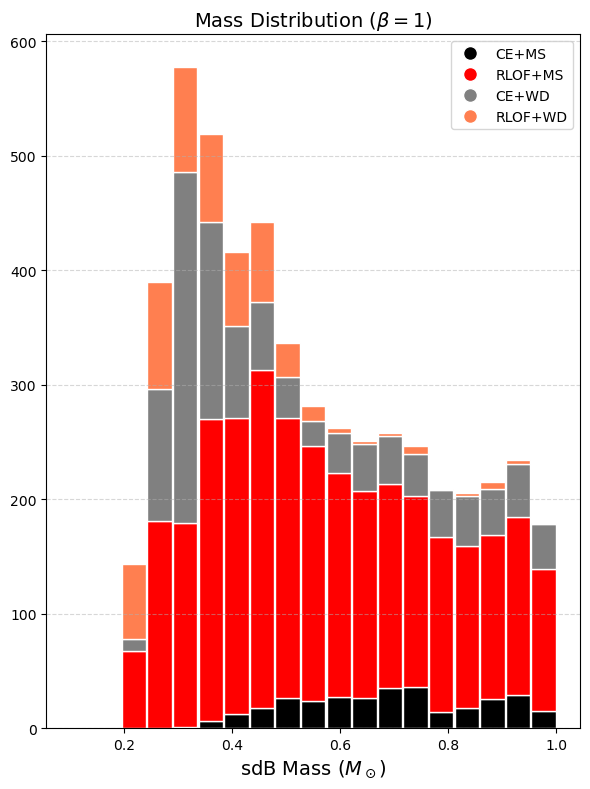

In [226]:
fig, axes = plt.subplots(1,1, figsize=(6,8))

bins = np.linspace(0.1,1,20)

ax=axes
ax.hist(all_masses, bins=bins, color=['black', 'red', 'grey', 'coral'], stacked=True, rwidth=0.95, edgecolor='white')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.5)

ax.set_title(r'Mass Distribution ($\beta = 1$)', fontsize=14)
ax.set_xlabel(r'sdB Mass ($M_\odot$)', fontsize=14)
ax.legend(handles=legend_3)

plt.tight_layout()
plt.savefig('Mass_Distribution_beta1.png', dpi=420)
plt.show()